# 1D harmonic oscillator physics-informed neural network (PINN)

$$
\dfrac{d^2 x}{d t^2} + \mu (1-x^2)\dfrac{d x}{d t} + x = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.

In [166]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [167]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

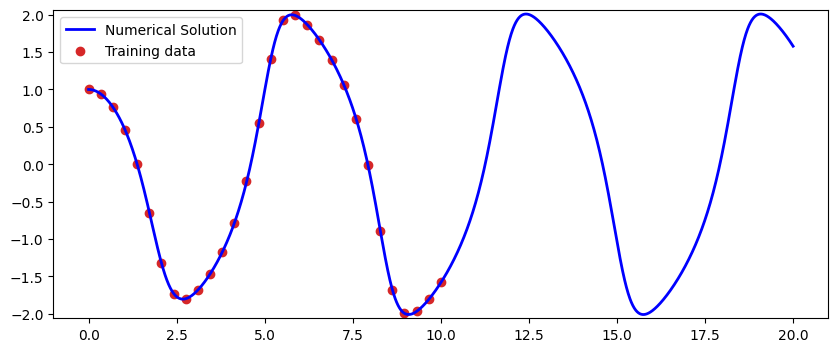

In [168]:
# Parameters and initial conditions

mu = 1
X0 = [1, 0]

# time domain
ti = 0
tf = 20
N  = 2000
t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], mu*(1-X[0]**2)*X[1]-X[0]]
    return dXdt

solution = odeint(ODE, X0, t.numpy().flatten())
x        = torch.from_numpy(solution[:,0]).view(-1,1)
x_max    = torch.max(torch.abs(x))

solution.dtype = np.double

# Pick a few points from the left hand side to be training data
t_data = torch.linspace(0, 10, 30).view(-1,1)
x_data = x[torch.searchsorted(t.flatten(), t_data.flatten())]

plt.figure(figsize=(10,4))

plt.plot(t, x, label="Numerical Solution", color='b', lw=2, alpha=1, linestyle='-')
plt.scatter(t_data, x_data, color="tab:red", label="Training data")

plt.ylim(-x_max-0.05, x_max+0.05)
plt.legend()
plt.show()

In [169]:
# Plotting Function

def plot_result(i, t, x, t_data, x_data, xh,tp=None,):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    
    plt.plot(t, x,  color="grey",     linewidth=2, alpha=1, label="solution")
    plt.plot(t, xh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data, x_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if tp is not None:
        plt.scatter(tp, -0*torch.ones_like(tp), s=10, color="tab:green", alpha=0.4, label='Physics loss training locations')
        
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(ti-0.1, tf+0.1)
    plt.ylim(-x_max-.1, x_max+5)
    plt.text(x_max, 0.7*x_max+5,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    
def plot_result2(t, x, t_data, x_data, tp=None,):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(t, x,  color="grey",     linewidth=2, alpha=1, label="solution")
    plt.scatter(t_data, x_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    plt.scatter(tp, -0*torch.ones_like(tp), s=10, color="tab:green", alpha=0.4, label='Physics loss training locations') 
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(ti-0.1, tf+0.1)
    plt.ylim(-x_max-.1, x_max+5)
    plt.axis("off")

## Normal neural network

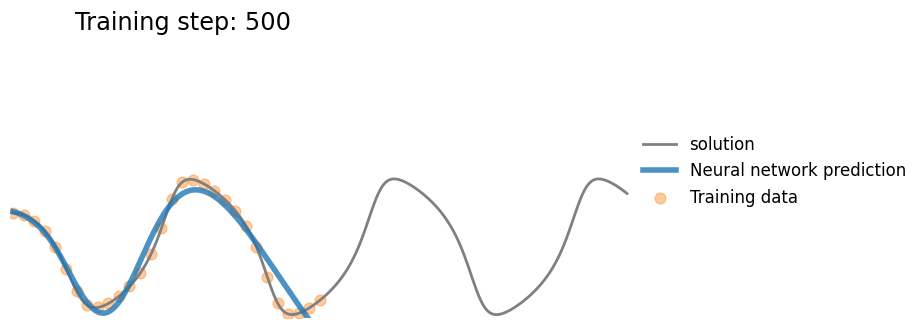

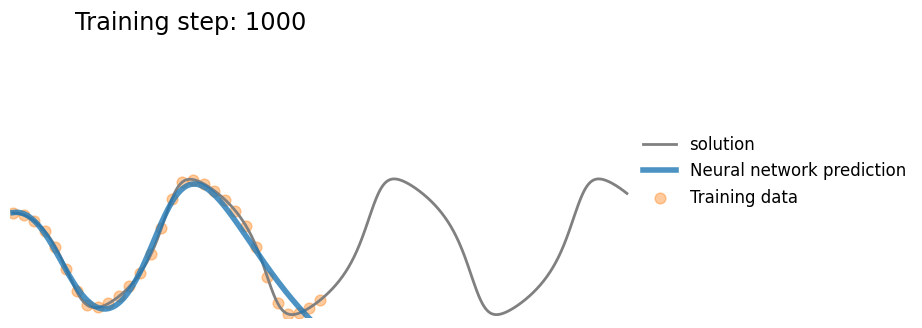

In [170]:
# train standard neural network to fit training data

torch.manual_seed(123)
model_NN = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model_NN.parameters(), lr=1e-3)
files = []

for i in range(1000):
    optimizer.zero_grad()
    xh = model_NN(t_data.to(torch.float32))
    loss = torch.mean((xh-x_data)**2) # use mean squared error
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        xh = model_NN(t).detach()
        
        plot_result(i, t, x, t_data, x_data, xh)
        
        file = "plots/NN_Van_der_Pol_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/NN_Van_der_Pol.gif", files, fps=20, loop=0)

## PINN

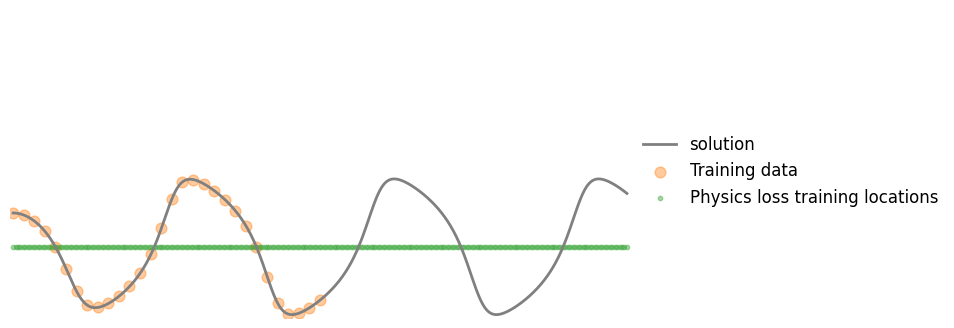

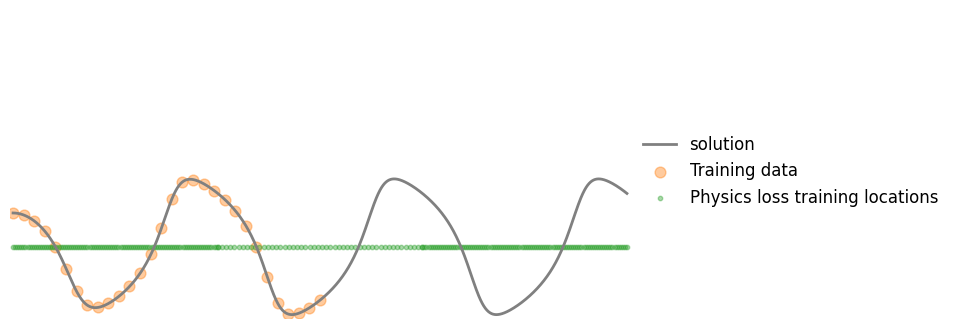

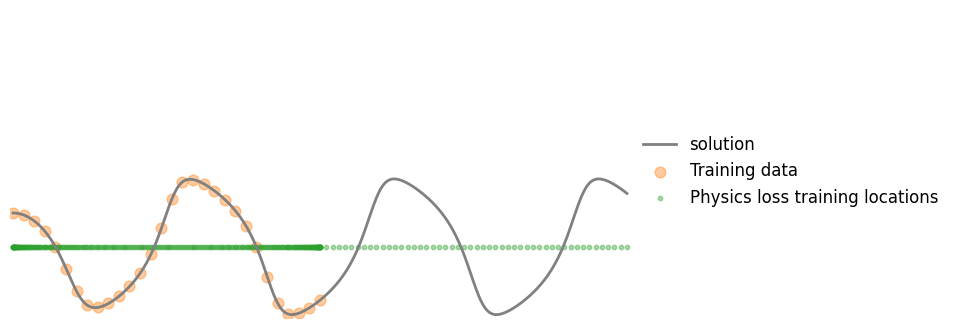

In [171]:
# collocation points

# uniform

Nc = 250
t_uniform = torch.linspace(ti, tf, Nc).view(-1,1).requires_grad_(True)
plot_result2(t, x, t_data, x_data, t_uniform.detach())

# Piece Wise

dt1 = torch.linspace(0, 20/3, 100)
dt2 = torch.linspace(20/3, 40/3, 50)
dt3 = torch.linspace(40/3, 20, 100)

t_piecewise = torch.cat([dt1, dt2, dt3]).view(-1,1).requires_grad_(True)
plot_result2(t, x, t_data, x_data, t_piecewise.detach())

# Chebychev

t_chebychev = torch.cat([(5*torch.cos(torch.arange(1,Nc)*np.pi/(Nc-1)) + 5), torch.linspace(10, 20, 50)]).view(-1,1).requires_grad_(True)
plot_result2(t, x, t_data, x_data, t_chebychev.detach())

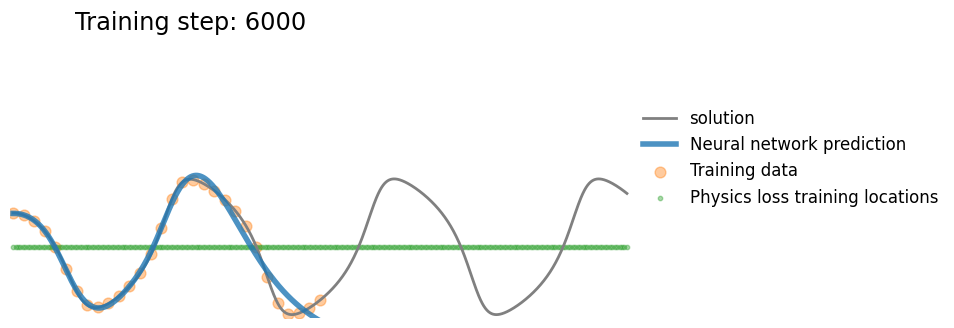

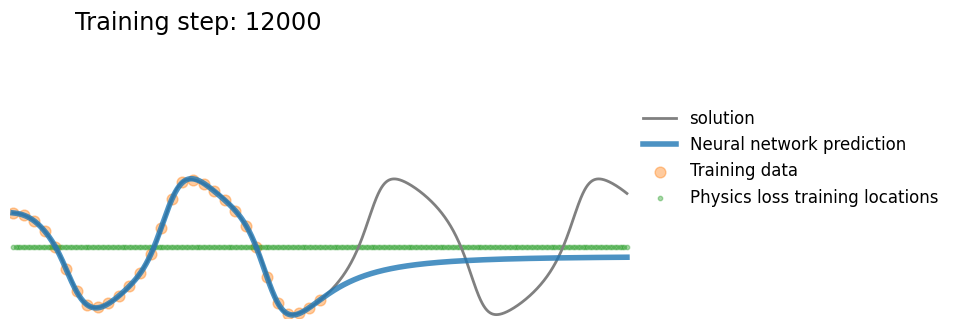

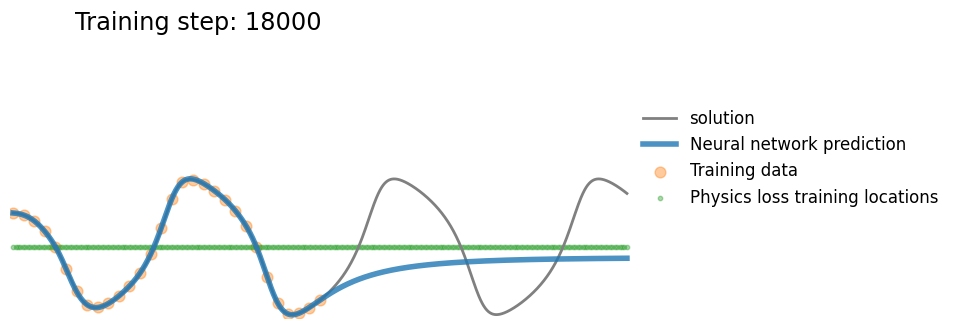

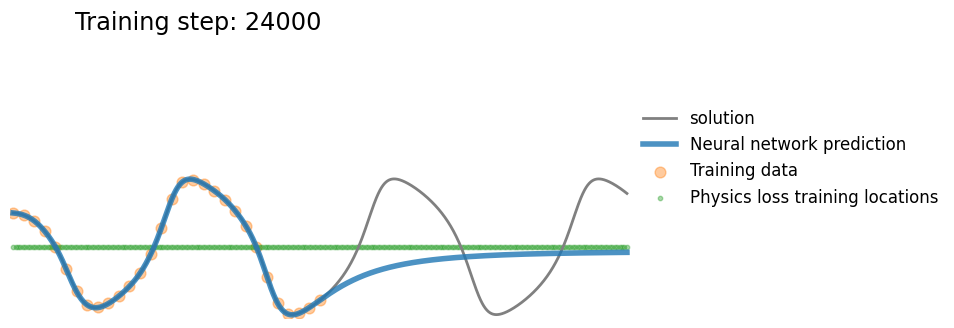

In [172]:
# Define the training with uniform collocation points

torch.manual_seed(123)
model_uniform = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model_uniform.parameters(), lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model_uniform(t_data)
    loss1 = torch.mean((xh-x_data)**2)# use mean squared error
    
    # compute the "physics loss"
    xhp = model_uniform(t_uniform)
    dx  = torch.autograd.grad(xhp, t_uniform, torch.ones_like(xhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  t_uniform, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 - mu*(1-xhp**2)*dx + xhp # computes the residual of the 1D Van der Pol differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        xh = model_uniform(t).detach()
        tp = t_uniform.detach()
        
        plot_result(i, t, x, t_data, x_data, xh, tp)
        
        file = "plots/pinn_Van_der_Pol_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/pinn_Van_der_Pol.gif", files, fps=20, loop=0)

In [ ]:
# Define the training with piecewise collocation points

torch.manual_seed(123)
model_piecewise = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model_piecewise.parameters(),lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model_piecewise(t_data)
    loss1 = torch.mean((xh-x_data)**2)# use mean squared error
    
    # compute the "physics loss"
    xhp = model_piecewise(t_piecewise)
    dx  = torch.autograd.grad(xhp, t_piecewise, torch.ones_like(xhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  t_piecewise, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 - mu*(1-xhp**2)*dx + xhp # computes the residual of the 1D Van der Pol differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        xh = model_piecewise(t).detach()
        tp = t_piecewise.detach()
        
        plot_result(i, t, x, t_data, x_data, xh, tp)
        
        file = "plots/pinn_Van_der_Pol_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/pinn_Van_der_Pol.gif", files, fps=20, loop=0)

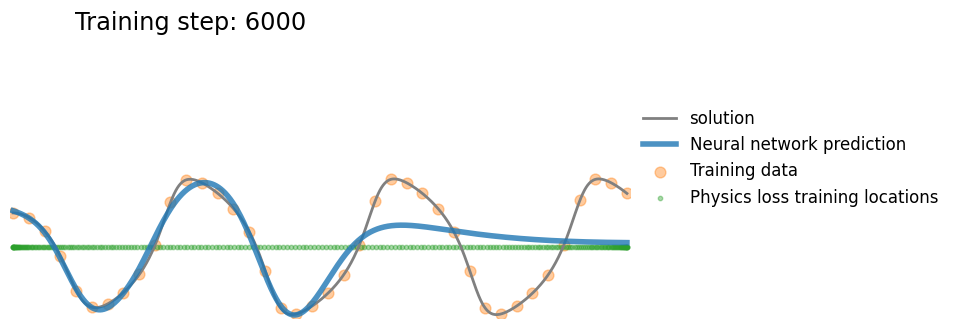

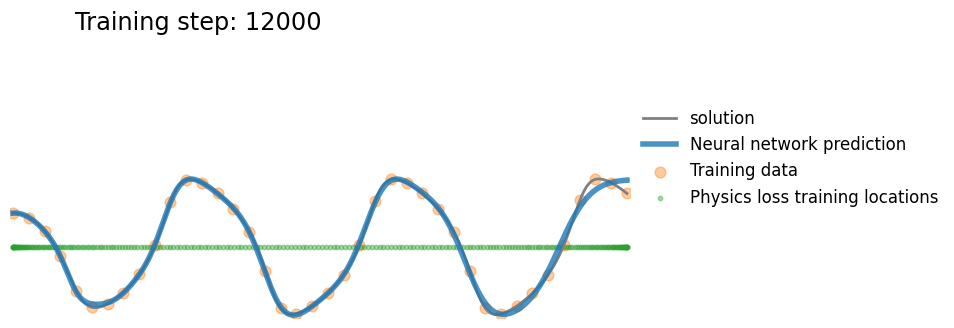

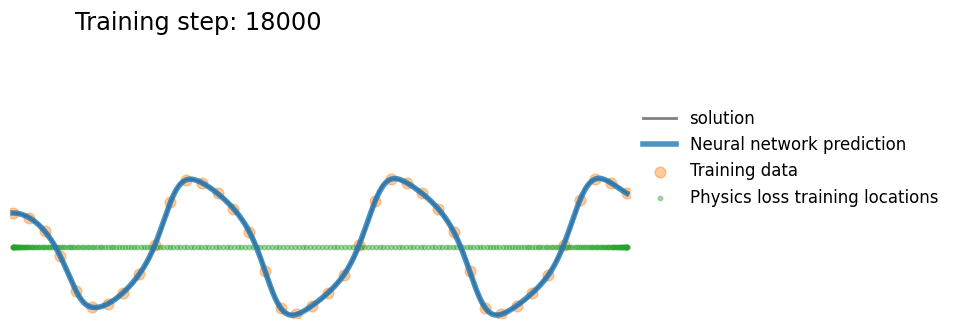

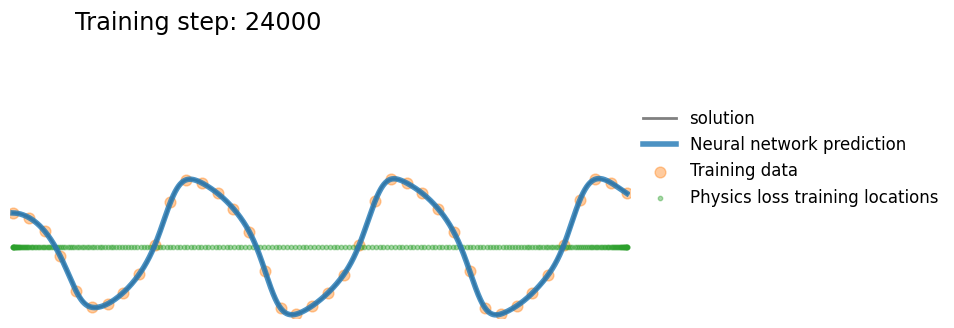

In [ ]:
# Define the training with chebychev collocation points

torch.manual_seed(123)
model_chebychev = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model_chebychev.parameters(),lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model_chebychev(t_data)
    loss1 = torch.mean((xh-x_data)**2)# use mean squared error
    
    # compute the "physics loss"
    xhp = model_chebychev(t_chebychev)
    dx  = torch.autograd.grad(xhp, t_chebychev, torch.ones_like(xhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  t_chebychev, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 - mu*(1-xhp**2)*dx + xhp # computes the residual of the 1D Van der Pol differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        xh = model_chebychev(t).detach()
        tp = t_chebychev.detach()
        
        plot_result(i, t, x, t_data, x_data, xh, tp)
        
        file = "plots/pinn_Van_der_Pol_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("gifs/pinn_Van_der_Pol.gif", files, fps=20, loop=0)

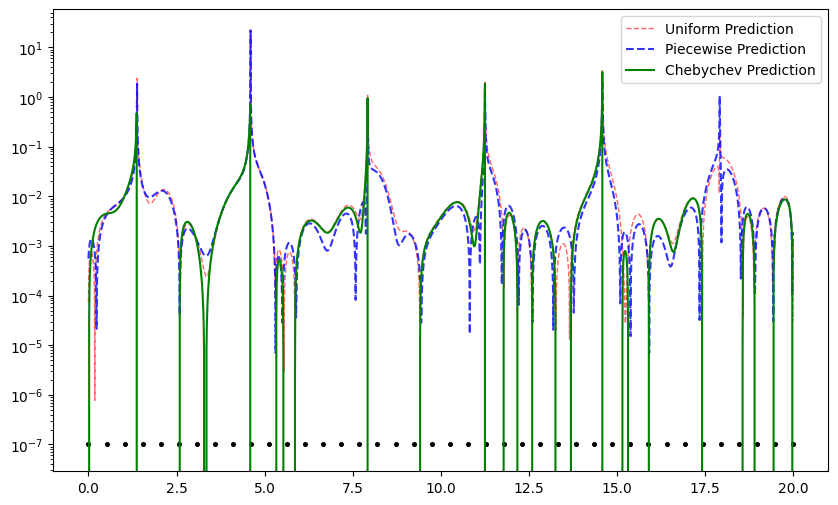

In [ ]:
x_cheby = model_chebychev(t).detach()
x_piecewise = model_piecewise(t).detach()
x_uniform = model_uniform(t).detach()

plt.figure(figsize=(10,6))
plt.plot(t, torch.abs((x-x_uniform)/x), linewidth=1, linestyle='--', label='Uniform Prediction', alpha=0.6, c='r')
plt.plot(t, torch.abs((x-x_piecewise)/x), linewidth=1.5, linestyle='--', label='Piecewise Prediction', alpha=0.8, c='b')
plt.plot(t, (x-x_cheby)/x, linewidth=1.5, linestyle='-', label='Chebychev Prediction', alpha=1, c='g')
plt.scatter(t_data, (1e-7)*torch.ones_like(t_data), s=7, c='k')
plt.yscale('log')
plt.legend()
plt.show()

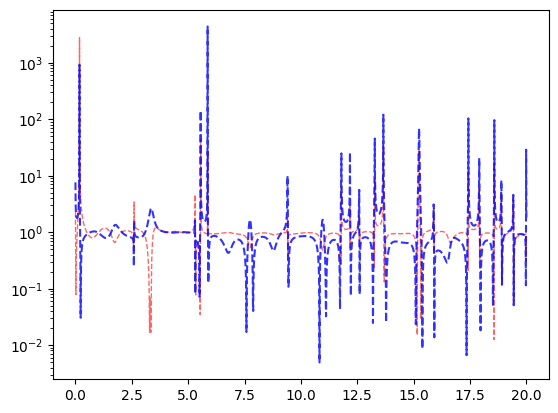

In [ ]:
plt.plot(t, torch.abs((x-x_cheby)/(x-x_uniform)), linewidth=1, linestyle='--', label='Uniform Prediction', alpha=0.6, c='r')
plt.plot(t, torch.abs((x-x_piecewise)/(x-x_uniform)), linewidth=1.5, linestyle='--', label='Piecewise Prediction', alpha=0.8, c='b')
plt.yscale('log')